# Coverage of MultiPLIER LV

The goal of this notebook is to examine why genes were found to be generic. Specifically, this notebook is trying to answer the question: Are generic genes found in more multiplier latent variables compared to specific genes?

The PLIER model performs a matrix factorization of gene expression data to get two matrices: loadings (Z) and latent matrix (B). The loadings (Z) are constrained to aligned with curated pathways and gene sets specified by prior knowledge [Figure 1B of Taroni et. al.](https://www.cell.com/cell-systems/pdfExtended/S2405-4712(19)30119-X). This ensure that some but not all latent variables capture known biology. The way PLIER does this is by applying a penalty such that the individual latent variables represent a few gene sets in order to make the latent variables more interpretable. Ideally there would be one latent variable associated with one gene set unambiguously.

While the PLIER model was trained on specific datasets, MultiPLIER extended this approach to all of recount2, where the latent variables should correspond to specific pathways or gene sets of interest. Therefore, we will look at the coverage of generic genes versus specific genes across these MultiPLIER latent variables.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import random
import pandas as pd
import seaborn as sns

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

from ponyo import utils
from generic_expression_patterns_modules import process

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
Using TensorFlow backend.


In [2]:
# Get data directory containing gene summary data
base_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))
data_dir = os.path.join(base_dir, "human_general_analysis")

# Read in config variables
config_filename = os.path.abspath(
    os.path.join(base_dir, "configs", "config_human_general.tsv")
)

params = utils.read_config(config_filename)

local_dir = params["local_dir"]

In [3]:
# Output file
#output_figure_filename = "LV_coverage.svg"

## Get gene data

Get generic and specific genes based on simulated gene ranking. Refer to [figure](https://github.com/greenelab/generic-expression-patterns/blob/master/human_general_analysis/gene_ranking_log2FoldChange.svg) as a guide.

* Generic genes >= 10000 (Having a high rank indicates that these genes are consistently changed across simulated experiments.)
* Specific genes: simulated rank < 5000 (Having a low rank indicates that these genes are not consistently changed across simulated experiments. It could also indicate genes that are consistently unchanged.)

In [4]:
# Get all gene summary file paths
ls_data_files = process.get_gene_summary_files(data_dir)

In [5]:
data = pd.read_csv(ls_data_files[0], sep="\t", index_col=0, header=0)
assert(data.shape[0] == len(data["Gene ID"].unique()))

In [6]:
generic_threshold = 10000
specific_threshold = 5000
dict_genes = process.get_generic_specific_genes(ls_data_files[0], generic_threshold, specific_threshold)

(17754, 10)
No. of generic genes: 4999
No. of specific genes: 5000
No. of generic genes: 7755


In [7]:
# Load multiplier models
# Converted formatted pickle files (loaded using phenoplier environment) from
# https://github.com/greenelab/phenoplier/blob/master/nbs/01_preprocessing/005-multiplier_recount2_models.ipynb
# into .tsv files
multiplier_model_z = pd.read_csv("multiplier_model_z.tsv", sep="\t", index_col=0, header=0)

In [8]:
# One off just to get a sense for how many genes are being compared
# Filter genes to only use those shared between our analysis and multiplier
# Check overlap between multiplier genes and our genes
multiplier_genes = list(multiplier_model_z.index)
our_genes = list(pd.read_csv(ls_data_files[0], sep="\t", index_col=0, header=0).index)
shared_genes = set(our_genes).intersection(multiplier_genes)

print(len(our_genes))
print(len(shared_genes))

17754
6374


In [9]:
# Drop gene ids not used in multiplier analysis
processed_dict_genes = process.process_generic_specific_gene_lists(dict_genes, multiplier_model_z)

## Get coverage of LVs

For each generic and specific gene we want to find:
1. The number of LVs that gene is present
2. The number of LVs that the gene contributes a lot to

**Expection/Motivation for this analysis**

### Nonzero LV coverage

In [10]:
dict_nonzero_coverage = process.get_nonzero_LV_coverage(processed_dict_genes, multiplier_model_z)

In [11]:
# Check genes aligned correctly
assert processed_dict_genes["generic"][0] in dict_nonzero_coverage["generic"].index

### High weight LV coverage

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


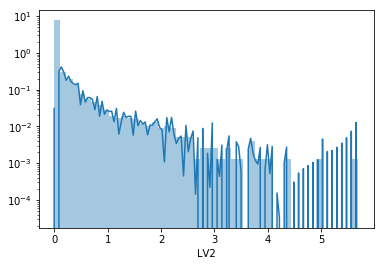

In [12]:
# Quick look at the distribution of gene weights per LV
import matplotlib.pyplot as plt
sns.distplot(multiplier_model_z["LV2"])
plt.yscale("log")

In [13]:
dict_highweight_coverage = process.get_highweight_LV_coverage(processed_dict_genes, multiplier_model_z, 0.9)

### Assemble LV coverage

In [14]:
all_coverage = []
for gene_label in dict_genes.keys():
    merged_df = pd.DataFrame(
        dict_nonzero_coverage[gene_label],
        columns= ["nonzero LV coverage"]
    ).merge(
        pd.DataFrame(
            dict_highweight_coverage[gene_label],
            columns= ["highweight LV coverage"]
        ),
        left_index=True,
        right_index=True
    ) 
    merged_df['gene type'] = gene_label
    all_coverage.append(merged_df)

all_coverage_df = pd.concat(all_coverage)

In [15]:
all_coverage_df.head()

,nonzero LV coverage,highweight LV coverage,gene type
EPN2,426,103,generic
SPIB,456,52,generic
CTSE,410,19,generic
NME8,347,40,generic
CLCN4,414,105,generic


Text(0.5, 1.0, 'Number of LVs genes are present in')

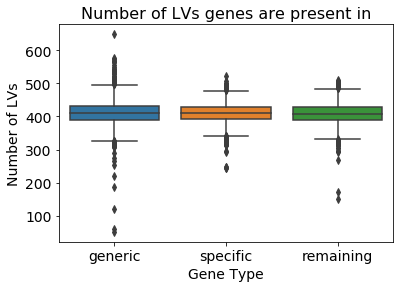

In [16]:
# Plot coverage distribution given list of generic coverage, specific coverage
import textwrap
nonzero_fig = sns.boxplot(data=all_coverage_df, 
                  x='gene type',
                  y='nonzero LV coverage')
nonzero_fig.set_xlabel("Gene Type",fontsize=14)
nonzero_fig.set_ylabel(textwrap.fill("Number of LVs", width=30),fontsize=14)
nonzero_fig.tick_params(labelsize=14)
nonzero_fig.set_title("Number of LVs genes are present in", fontsize=16)

Text(0.5, 1.0, 'Number of LVs genes contribute highly to')

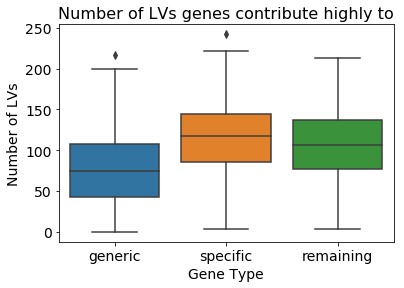

In [17]:
# Plot coverage distribution given list of generic coverage, specific coverage
import textwrap
highweight_fig = sns.boxplot(data=all_coverage_df, 
                  x='gene type',
                  y='highweight LV coverage')
highweight_fig.set_xlabel("Gene Type",fontsize=14)
highweight_fig.set_ylabel(textwrap.fill("Number of LVs", width=30),fontsize=14)
highweight_fig.tick_params(labelsize=14)
highweight_fig.set_title("Number of LVs genes contribute highly to", fontsize=16)

Its not surprising that there was more coverage for generic genes vs specific genes because there were many more generic genes found. What if we try to randomly sample a generic gene set that is of the same size as the number of specific genes?

In [18]:
"""# Randomly generate generic gene list that is the same size as specific gene list
# Re-run coverage analysis
# Find the number of generic and specific genes that have a nonzero contribution to LV
generic_cov_matched = []
specific_cov_matched = []
num_significant_LVs = multiplier_model_z_processed.shape[1]

for ifile in range(len(ls_data_files)):
    generic_genes = ls_genes_out[ifile][0]
    specific_genes = ls_genes_out[ifile][1]
    
    # Only include those genes that are in multiplier otherwise will get NAs
    generic_genes_processed, specific_genes_processed = process.process_generic_specific_gene_lists(
        generic_genes, 
        specific_genes, 
        multiplier_model_z_processed
    )
    
    # Randomly generate generic gene list that is the same size as specific gene list
    generic_genes_processed_subset = random.sample(generic_genes_processed, len(specific_genes_processed))
    print(len(generic_genes_processed_subset), len(specific_genes_processed))
    
    
    generic_cov_i, specific_cov_i = process.get_LV_coverage(
        generic_genes_processed_subset,
        specific_genes_processed,
        multiplier_model_z_processed
    )
    
    generic_cov_matched.append(len(generic_cov_i)/num_significant_LVs)
    specific_cov_matched.append(len(specific_cov_i)/num_significant_LVs)
    
gene_cov_matched = pd.DataFrame({'Proportion of significantly associated LVs covered': generic_cov_matched + specific_cov_matched,
                         'gene type': ['generic']*len(ls_data_files) + ['specific']*len(ls_data_files) 
                      })"""

"# Randomly generate generic gene list that is the same size as specific gene list\n# Re-run coverage analysis\n# Find the number of generic and specific genes that have a nonzero contribution to LV\ngeneric_cov_matched = []\nspecific_cov_matched = []\nnum_significant_LVs = multiplier_model_z_processed.shape[1]\n\nfor ifile in range(len(ls_data_files)):\n    generic_genes = ls_genes_out[ifile][0]\n    specific_genes = ls_genes_out[ifile][1]\n    \n    # Only include those genes that are in multiplier otherwise will get NAs\n    generic_genes_processed, specific_genes_processed = process.process_generic_specific_gene_lists(\n        generic_genes, \n        specific_genes, \n        multiplier_model_z_processed\n    )\n    \n    # Randomly generate generic gene list that is the same size as specific gene list\n    generic_genes_processed_subset = random.sample(generic_genes_processed, len(specific_genes_processed))\n    print(len(generic_genes_processed_subset), len(specific_genes_proce

In [19]:
"""# Plot coverage distribution given list of generic coverage, specific coverage
print(generic_cov_matched)
print(specific_cov_matched)

import textwrap
fig2 = sns.swarmplot(data=gene_cov_matched, 
                  x='gene type', 
                  y='Proportion of significantly associated LVs covered', 
                  palette=['grey','powderblue'])
fig2.set_xlabel("Gene Type",fontsize=14)
fig2.set_ylabel(textwrap.fill("Proportion of pathway-associated LVs covered", width=30),fontsize=14)
fig2.tick_params(labelsize=14)
fig2.set_title("Coverage of pathway-associated LVs", fontsize=16)"""

'# Plot coverage distribution given list of generic coverage, specific coverage\nprint(generic_cov_matched)\nprint(specific_cov_matched)\n\nimport textwrap\nfig2 = sns.swarmplot(data=gene_cov_matched, \n                  x=\'gene type\', \n                  y=\'Proportion of significantly associated LVs covered\', \n                  palette=[\'grey\',\'powderblue\'])\nfig2.set_xlabel("Gene Type",fontsize=14)\nfig2.set_ylabel(textwrap.fill("Proportion of pathway-associated LVs covered", width=30),fontsize=14)\nfig2.tick_params(labelsize=14)\nfig2.set_title("Coverage of pathway-associated LVs", fontsize=16)'

In [20]:
"""# Save plot
fig.figure.savefig(
        output_figure_filename,
        format="svg",
        bbox_inches="tight",
        transparent=True,
        pad_inches=0,
        dpi=300,
    )"""

'# Save plot\nfig.figure.savefig(\n        output_figure_filename,\n        format="svg",\n        bbox_inches="tight",\n        transparent=True,\n        pad_inches=0,\n        dpi=300,\n    )'

**Takeaway:**
* On average, specific genes cover fewer pathway-associated LVs compared to generic genes, which were found to be linked to all pathway-associated LVs.
* Warning: This difference in coverage is not surprising given the fact that there 1-6 specific genes identified compared to the ~1000 generic genes found.
* Some of the LVs that were only found to have generic genes (see [table](generic_only_LV_summary.tsv)) include mainly immune response pathways (monocytes, mast cell activation), wound healing (collagen formation), cell signaling (focal adhesion, integrin1) 

**Overall, it looks like generic genes are associated with many pathways, acting as *gene hubs*, which is why they are "generic"**